In [1]:
import os
import zarr
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt

# Import scipy norm function
from scipy.linalg import norm

from src.dataset import get_normalizer
from src.dataset.normalizer import Normalizer
from src.common.geometry import np_rot_6d_to_rotvec, np_rotvec_to_rot_6d

In [4]:
normalize: Normalizer = get_normalizer(normalizer_type="min_max", control_mode="delta")

In [11]:
teleop = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr",
    mode="r",
)

scripted = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/one_leg/scripted/low/success.zarr",
    mode="r",
)

In [12]:
list(teleop.keys()), teleop["action/delta"].shape

(['action',
  'color_image1',
  'color_image2',
  'episode_ends',
  'furniture',
  'parts_poses',
  'pickle_file',
  'reward',
  'robot_state',
  'skill',
  'success'],
 (29020, 10))

In [13]:
# Get the relevant data for the teleop and scripted data
# Teleop
t_episode_ends = teleop["episode_ends"][:]
t_deltas = teleop["action/delta"][:]
t_pos = teleop["action/pos"][:]

# Split into episodes
t_ep_delta = np.split(t_deltas, t_episode_ends[:-1])
t_ep_pos = np.split(t_pos, t_episode_ends[:-1])

# Scripted
s_episode_ends = scripted["episode_ends"][:]
s_deltas = scripted["action/delta"][:]
s_pos = scripted["action/pos"][:]

# Split into episodes
s_ep_delta = np.split(s_deltas, s_episode_ends[:-1])
s_ep_pos = np.split(s_pos, s_episode_ends[:-1])

In [14]:
def plot_episode(
    episode: np.ndarray, demo_source: str, include_normalized: bool = False
):
    # Now we'll plot the norm of the delta positions and the delta rotations in the first row
    # and the normalized versions in the second row
    fig, ax = plt.subplots(
        nrows=(1 + int(include_normalized)),
        ncols=2,
        figsize=(16, 4 * (1 + int(include_normalized))),
        squeeze=False,
    )

    # Start with the raw values
    delta_pos_norm = norm(episode[:, :3], axis=1)
    delta_rot_norm = norm(np_rot_6d_to_rotvec(episode[:, 3:9]), axis=1)

    ax[0, 0].plot(delta_pos_norm, label="delta_pos_norm")
    ax[0, 1].plot(delta_rot_norm, label="delta_rot_norm")

    # Set labels
    ax[0, 0].set_title("delta_pos_norm")
    ax[0, 1].set_title("delta_rot_norm")

    # Now the normalized values
    if include_normalized:
        normalized_delta = normalize(episode, key="action", forward=True)
        delta_pos_norm = norm(normalized_delta[:, :3], axis=1)
        delta_rot_norm = norm(np_rot_6d_to_rotvec(normalized_delta[:, 3:9]), axis=1)

        ax[1, 0].plot(delta_pos_norm, label="normalized_delta_pos_norm")
        ax[1, 1].plot(delta_rot_norm, label="normalized_delta_rot_norm")

        # Set labels
        ax[1, 0].set_title("normalized_delta_pos_norm")
        ax[1, 1].set_title("normalized_delta_rot_norm")

    fig.suptitle(f"Norm of delta positions and rotations for {demo_source} episode")

## Plot delta actions

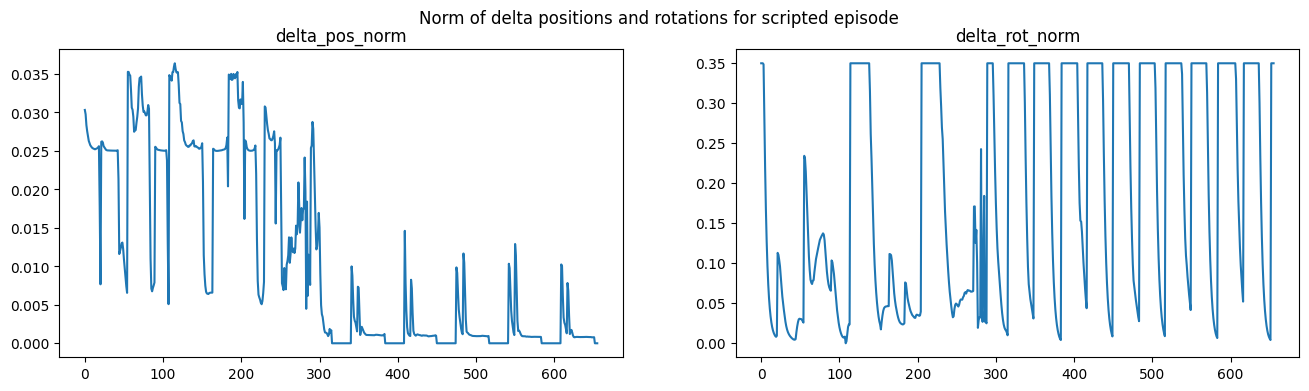

In [32]:
# Run the plot function for one episode of scripted
plot_episode(s_ep_delta[0], "scripted")

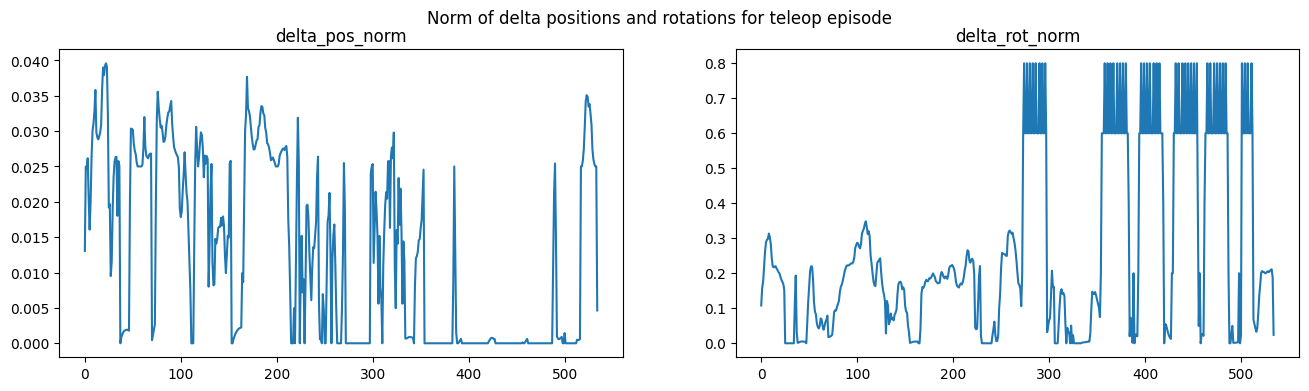

In [33]:
# Run the plot function for the first episode
plot_episode(t_ep_delta[0], "teleop")

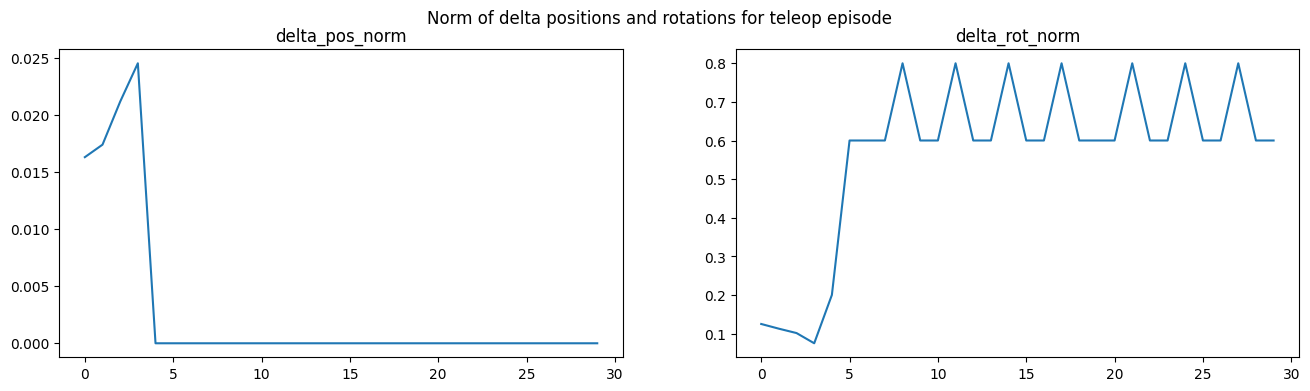

In [36]:
# Let's zoom in in the timesteps between 350 and 380
plot_episode(t_ep_delta[0][350:380], "teleop")

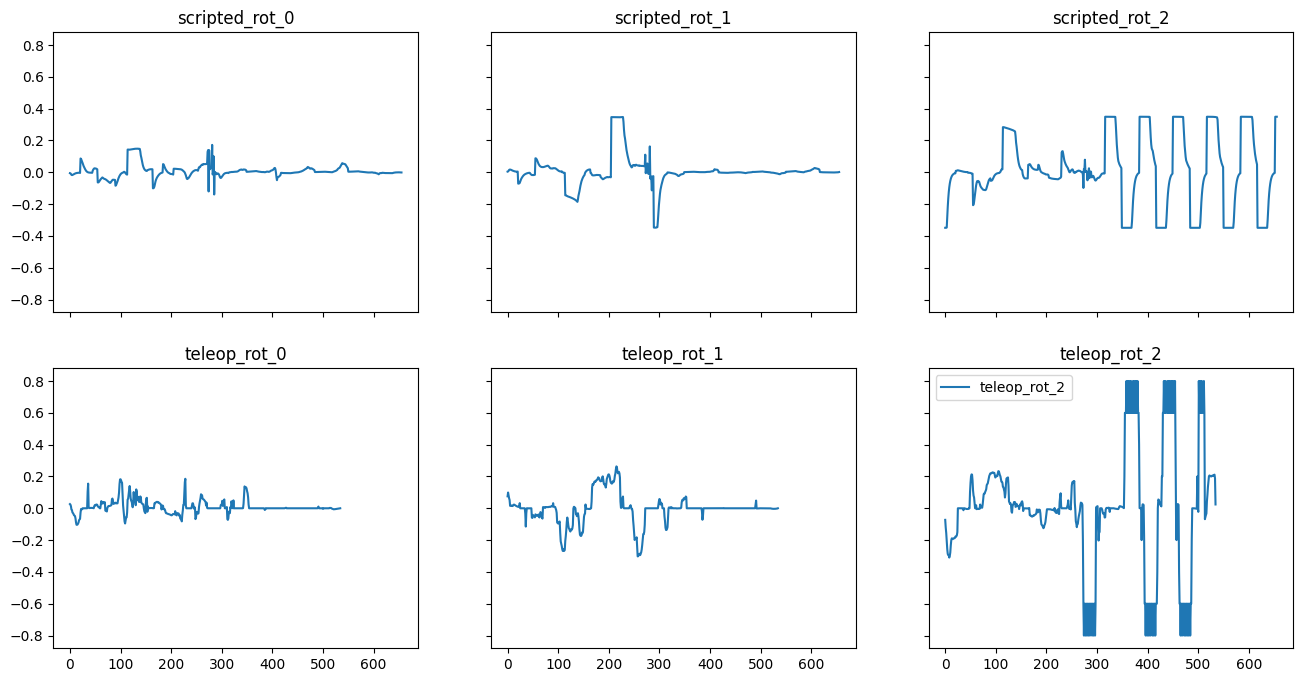

In [43]:
# Plot the values of the raw rotation vector coordinates for the first episode
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

for i in range(3):
    ax[0, i].plot(
        np_rot_6d_to_rotvec(s_ep_delta[0][:, 3:9])[:, i], label=f"scripted_rot_{i}"
    )
    ax[0, i].set_title(f"scripted_rot_{i}")

    ax[1, i].plot(
        np_rot_6d_to_rotvec(t_ep_delta[0][:, 3:9])[:, i], label=f"teleop_rot_{i}"
    )
    ax[1, i].set_title(f"teleop_rot_{i}")

## Plot absolute actions

In [10]:
plot_episode(s_ep_pos[0], "scripted")

NameError: name 's_ep_pos' is not defined

## clip the z-rotation as a band-aid fix

In [3]:
clip_mag = 0.35

teleop = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr",
    mode="a",
)

In [4]:
# Get the delta actions
teleop_deltas = teleop["action/delta"][:]

# Convert to rotation vectors
teleop_rotvecs = np_rot_6d_to_rotvec(teleop_deltas[:, 3:9])

# Clip the z-axis of the magnitude of the rotation vectors
teleop_rotvecs[:, 2] = np.clip(teleop_rotvecs[:, 2], -clip_mag, clip_mag)

# Convert back to 6D
teleop_deltas[:, 3:9] = np_rotvec_to_rot_6d(teleop_rotvecs)

# Save the changes
teleop["action/delta"] = teleop_deltas

In [6]:
# Teleop
t_episode_ends = teleop["episode_ends"][:]
t_deltas = teleop["action/delta"][:]
t_pos = teleop["action/pos"][:]

# Split into episodes
t_ep_delta = np.split(t_deltas, t_episode_ends[:-1])
t_ep_pos = np.split(t_pos, t_episode_ends[:-1])

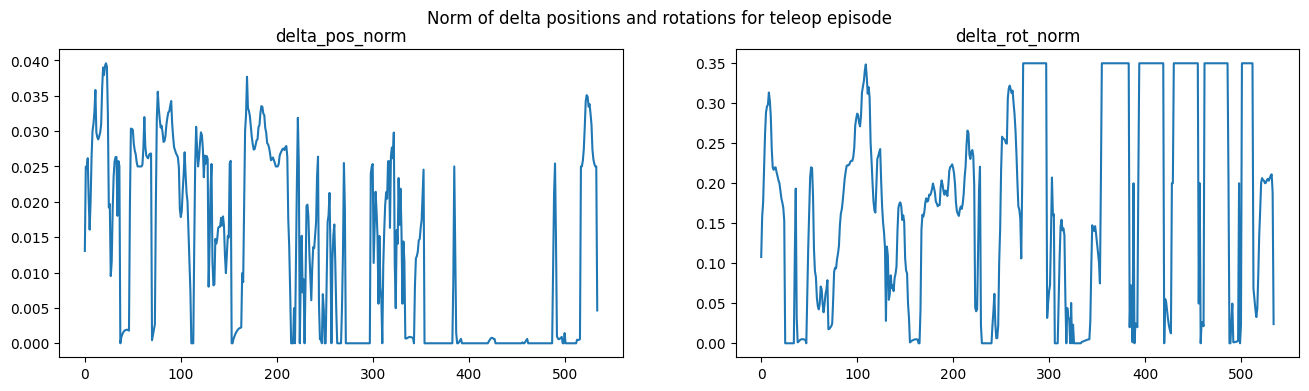

In [9]:
# Plot the teleop episode again
plot_episode(t_ep_delta[0], "teleop")